<div><img style="float: right; width: 120px; vertical-align:rigth" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />



<h1><center>Autoencoder: Eliminación de píxeles Negros</center></h1>

<center>Proyecto de Ciencia de Datos</center>
<center>Grado en Ciencia de Datos e Inteligencia Artificial</center>
<center>Escuela Técnica Superior de Ingeniería de Sistemas Informáticos</center>
<center>2023-2024</center>



En este notebook, se va a proceder a utilizar las imágenes de Standford Cars perturbándolas añadiendo de manera aleatoria píxeles negros. El objetivo es que mediante un autoencoder, el modelo pueda ser capaz de eliminar dichos píxeles.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Import Libraries


In [2]:
import os

# Obtain current working directory
os.chdir('..')

In [3]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from settings import settings
from keras.utils import plot_model
from auxiliar_functions.plot_functions import plot_samples
from auxiliar_functions.perturbation import add_black_pixels

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2DTranspose, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2023-12-13 22:09:41.399835: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 22:09:41.399890: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 22:09:41.399907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Check GPU Availability

Las siguientes 3 celdas nos permiten comprobar si tenemos GPU disponible para su uso en el notebook.

In [4]:
# Check if GPU is running
print(len(tf.config.list_physical_devices('GPU')) > 0)

# See GPU devices in use
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Set memory growth to True. This will allow to allocate memory as needed
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load and Visualize the Dataset

A continuación, se cargan las imágenes del dataset y se visualizan algunas de ellas. Todos los directorios que se van a utilizar en este repositorio se van a almacenar en la <span style="color:#20B2AA">**settings.py**</span> para su fácil acceso.

In [5]:
# Get train and test paths
train_path, test_path = settings.train, settings.test

# Load train and test data
train = pd.read_csv(settings.data_train, header=None)
test = pd.read_csv(settings.data_test, header=None)
train.shape, test.shape

((8144, 6), (8041, 6))

El archivo <span style="color:#20B2AA">**names.csv**</span> contiene los 196 nombres de las clases de coches que se van a utilizar en este proyecto. Se requiere un pequeño preprocesamiento para sustituir $/$ por $-$ dado que posteriormente se van a utilizar como nombres de carpetas y los $/$ ocasionan problemas.

In [6]:
# Load model names
model_names = pd.read_csv(settings.car_model, header=None)[0].tolist()

# Correct model names for them to be turned into folder name
model_names = [name.replace('/', '-') for name in model_names]

print(len(model_names), '\n', model_names[:5])

196 
 ['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012']


In [7]:
train.head()

0    1    2     3     4    5
0  00001.jpg   39  116   569   375   14
1  00002.jpg   36  116   868   587    3
2  00003.jpg   85  109   601   381   91
3  00004.jpg  621  393  1484  1096  134
4  00005.jpg   14   36   133    99  106

El dataset contiene las siguientes columnas:

- La columna 0 contiene el nombre de la imagen dentro de cada carpeta.
- La columna 1 hace referencia a la coordenada `x` del punto superior izquierdo del cuadro delimitador.
- La columna 2 hace referencia a la coordenada `y` del punto superior izquierdo del cuadro delimitador.
- La columna 3 hace referencia a la coordenada `x` del punto inferior derecho del cuadro delimitador.
- La columna 4 hace referencia a la coordenada `y` del punto inferior derecho del cuadro delimitador.
- La columna 5 hace referencia a la clase del coche.

Mediante el archivo que contiene los diferentes modelos y la columna 5 del dataset, se obtiene el nombre de la clase del coche al que pertenece cada imagen.

<span style="color:orange">**NOTA**</span>: Dado que el carácter $/$ ocasiona problemas en el nombre de las carpetas, se ha optado por sustituirlo por $-$, que es la manera en la que se nomrbra a las carpetas con cada modelo.

In [8]:
# Change Column Names
train.columns = test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']
test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']

# For each item in df, find the corresponding model name
train['model'] = train.label.apply(lambda x: model_names[x-1])
test['model'] = test.label.apply(lambda x: model_names[x-1])

# Correct model names for them to be turned into folder name
train['model'] = train.model.apply(lambda x: x.replace('/', '-'))
test['model'] = test.model.apply(lambda x: x.replace('/', '-'))

In [9]:
train.head()

img_name    x    y  width  height  label  \
0  00001.jpg   39  116    569     375     14   
1  00002.jpg   36  116    868     587      3   
2  00003.jpg   85  109    601     381     91   
3  00004.jpg  621  393   1484    1096    134   
4  00005.jpg   14   36    133      99    106   

                                 model  
0                  Audi TTS Coupe 2012  
1                  Acura TL Sedan 2012  
2           Dodge Dakota Club Cab 2007  
3     Hyundai Sonata Hybrid Sedan 2012  
4  Ford F-450 Super Duty Crew Cab 2012

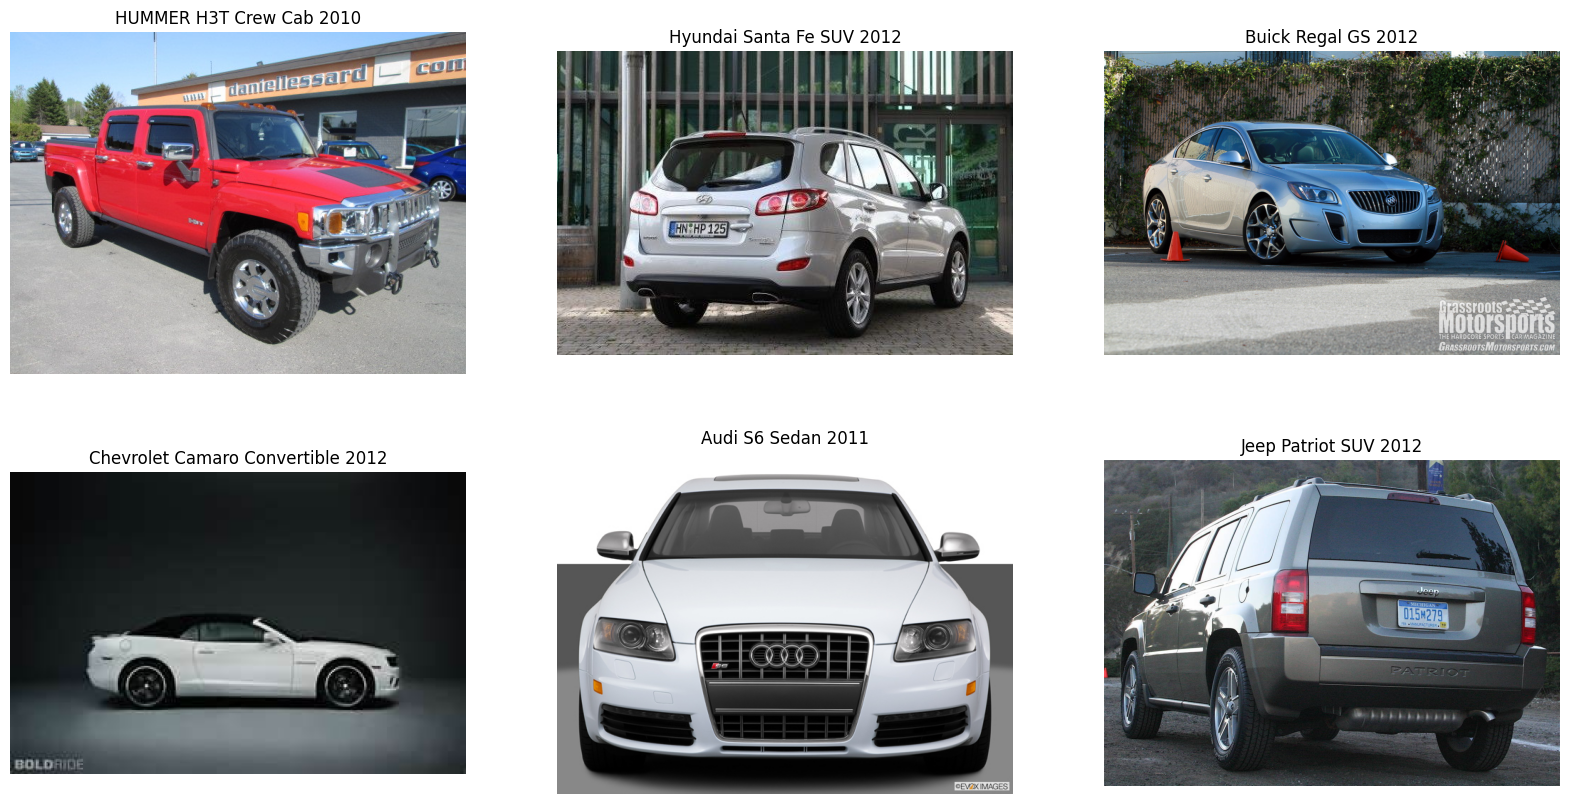

In [10]:
plot_samples(train)

In [11]:
# Check Image Sizes
sample_img = plt.imread(settings.train + train['model'][0] + '/00001.jpg')
print(f'Las dimensiones de la imagen son: {sample_img.shape}')

Las dimensiones de la imagen son: (400, 600, 3)


## Clasificación de imágenes con Ruido

In [12]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [13]:
TARGET_SIZE = (128, 128)
BATCH_SIZE = 32

black_pixels = 50   # Number of black pixels to add to each image
num_classes = len(model_names)

In [14]:
# Create new train and test generators
train_datagen_black_pixels = ImageDataGenerator(rescale=1./255,
                                                preprocessing_function=lambda x: add_black_pixels(x, black_pixels))

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen_black_pixels.flow_from_directory(train_path, 
                                                                 target_size=TARGET_SIZE, 
                                                                 batch_size=BATCH_SIZE, 
                                                                 class_mode='input',
                                                                 subset='training')

validation_generator = train_datagen.flow_from_directory(train_path,
                                                         target_size=TARGET_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='input',
                                                         subset='validation')

test_generator = test_datagen.flow_from_directory(test_path, 
                                                  target_size=TARGET_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='input')

Found 8144 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


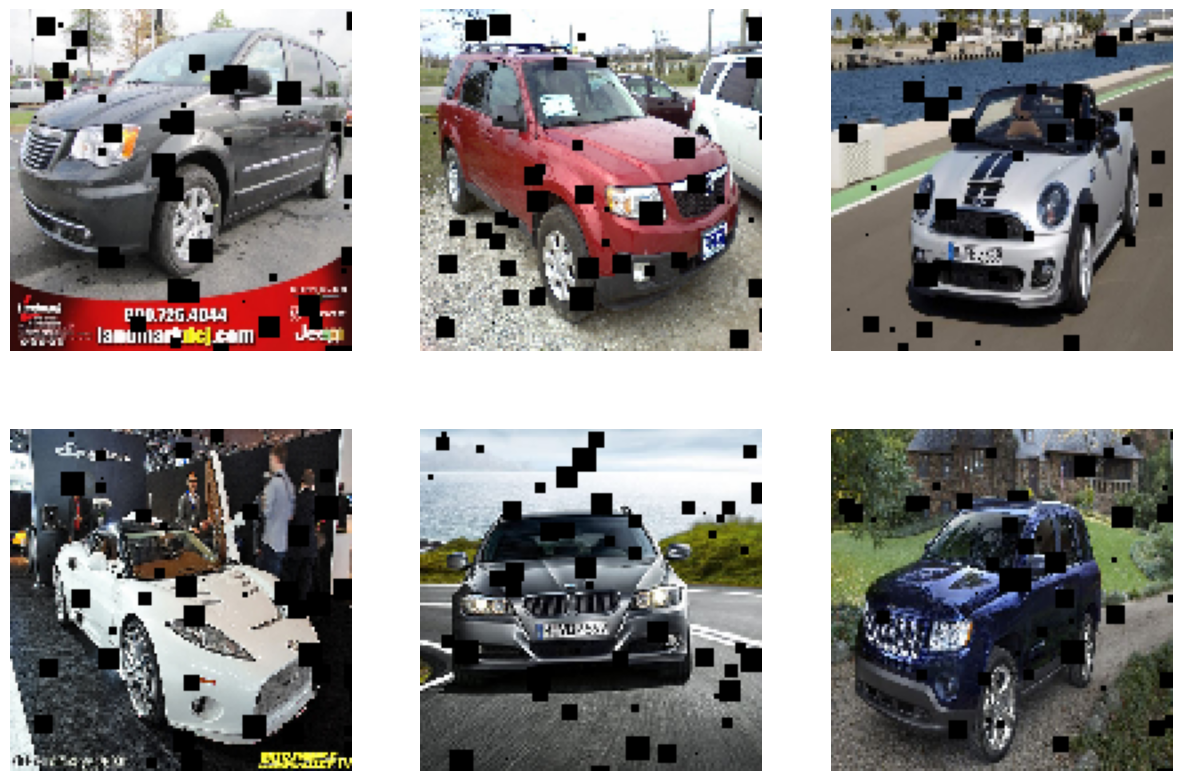

In [27]:
# Visualize SAMPLE images with black pixels
figs, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

for i, ax in enumerate(axs.flatten()):
    x, y = train_generator.next()
    ax.imshow(x[i])
    ax.axis('off')

In [16]:
def Autoencoder_Model(input_shape):
    
    img_input = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', strides=2)(img_input)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', strides=2)(x)
    
    # Decoder
    x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', padding='same', strides=2)(x)
    x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', padding='same', strides=1)(x)
    x = Conv2DTranspose(filters=3, kernel_size=3, activation='sigmoid', padding='same', strides=2)(x)  
    output = x

    model = Model(inputs=img_input, outputs=output)
    
    return model

In [17]:
input_shape = TARGET_SIZE + (3,)
autoencoder = Autoencoder_Model(input_shape)

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_transpose (Conv2DTr  (None, 64, 64, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 128, 128, 3)       867   

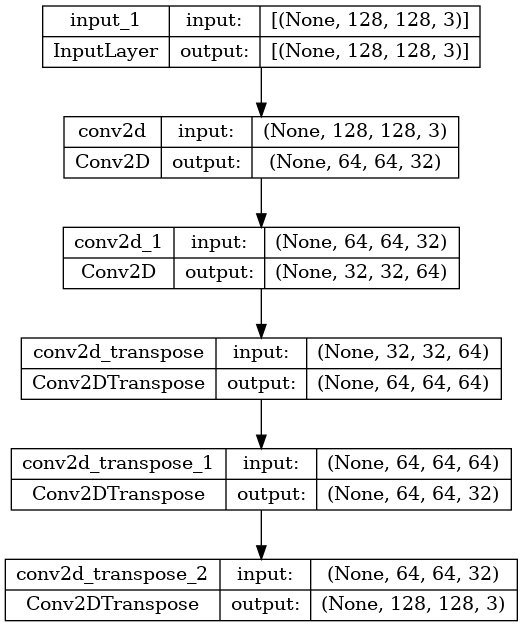

In [18]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True)

In [19]:
history_path = settings.autoencoder_model + '/history.pkl'

try:
    # Open model file
    autoencoder = load_model(settings.autoencoder_model)
    print('Model loaded')
    
    # Open history file
    with open(history_path, 'rb') as file:
        history = pickle.load(file)
        
except:
    print('Model not found')
    print('Training model...')

    # Create callbacks
    checkpoint = ModelCheckpoint(settings.autoencoder_model, save_best_only=True, monitor='val_loss', mode='min',verbose=1)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
    
    # Train model
    autoencoder_history = autoencoder.fit(train_generator,
                                          epochs=100,
                                          batch_size=128,
                                          validation_data=validation_generator,
                                          callbacks=[checkpoint, early_stopping])
    
    # Save history
    with open(history_path, 'wb') as file:
        pickle.dump(autoencoder_history, file)


Model loaded
Model not found
Training model...
Epoch 1/100
255/255 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.6282
Epoch 1: val_loss improved from inf to 0.00697, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 119s 455ms/step - loss: 0.0118 - accuracy: 0.6282 - val_loss: 0.0070 - val_accuracy: 0.6465
Epoch 2/100
255/255 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.6469
Epoch 2: val_loss improved from 0.00697 to 0.00525, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 114s 444ms/step - loss: 0.0073 - accuracy: 0.6469 - val_loss: 0.0053 - val_accuracy: 0.6717
Epoch 3/100
255/255 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.6492
Epoch 3: val_loss improved from 0.00525 to 0.00433, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 107s 419ms/step - loss: 0.0056 - accuracy: 0.6492 - val_loss: 0.0043 - val_accuracy: 0.6550
Epoch 4/100
255/255 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.6571
Epoch 4: val_loss improved from 0.00433 to 0.00364, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 90s 351ms/step - loss: 0.0046 - accuracy: 0.6571 - val_loss: 0.0036 - val_accuracy: 0.6790
Epoch 5/100
255/255 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.6786
Epoch 5: val_loss improved from 0.00364 to 0.00312, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 86s 338ms/step - loss: 0.0044 - accuracy: 0.6786 - val_loss: 0.0031 - val_accuracy: 0.6938
Epoch 6/100
255/255 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.6951
Epoch 6: val_loss did not improve from 0.00312
255/255 [==============================] - 81s 318ms/step - loss: 0.0033 - accuracy: 0.6951 - val_loss: 0.0035 - val_accuracy: 0.7168
Epoch 7/100
255/255 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.7065
Epoch 7: val_loss improved from 0.00312 to 0.00243, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 83s 325ms/step - loss: 0.0030 - accuracy: 0.7065 - val_loss: 0.0024 - val_accuracy: 0.7206
Epoch 8/100
255/255 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.7143
Epoch 8: val_loss improved from 0.00243 to 0.00216, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 108s 420ms/step - loss: 0.0027 - accuracy: 0.7143 - val_loss: 0.0022 - val_accuracy: 0.7090
Epoch 9/100
255/255 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.7164
Epoch 9: val_loss improved from 0.00216 to 0.00203, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 112s 438ms/step - loss: 0.0024 - accuracy: 0.7164 - val_loss: 0.0020 - val_accuracy: 0.7296
Epoch 10/100
255/255 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.7191
Epoch 10: val_loss improved from 0.00203 to 0.00184, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 112s 438ms/step - loss: 0.0022 - accuracy: 0.7191 - val_loss: 0.0018 - val_accuracy: 0.7347
Epoch 11/100
255/255 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.7114
Epoch 11: val_loss improved from 0.00184 to 0.00174, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 113s 442ms/step - loss: 0.0022 - accuracy: 0.7114 - val_loss: 0.0017 - val_accuracy: 0.7276
Epoch 12/100
255/255 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.7218
Epoch 12: val_loss improved from 0.00174 to 0.00160, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 151s 591ms/step - loss: 0.0018 - accuracy: 0.7218 - val_loss: 0.0016 - val_accuracy: 0.7252
Epoch 13/100
255/255 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.7198
Epoch 13: val_loss improved from 0.00160 to 0.00143, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 155s 607ms/step - loss: 0.0018 - accuracy: 0.7198 - val_loss: 0.0014 - val_accuracy: 0.7480
Epoch 14/100
255/255 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.7276
Epoch 14: val_loss did not improve from 0.00143
255/255 [==============================] - 148s 580ms/step - loss: 0.0016 - accuracy: 0.7276 - val_loss: 0.0020 - val_accuracy: 0.6768
Epoch 15/100
255/255 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.7303
Epoch 15: val_loss improved from 0.00143 to 0.00123, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 100s 390ms/step - loss: 0.0015 - accuracy: 0.7303 - val_loss: 0.0012 - val_accuracy: 0.7247
Epoch 16/100
255/255 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.7342
Epoch 16: val_loss improved from 0.00123 to 0.00116, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 108s 420ms/step - loss: 0.0014 - accuracy: 0.7342 - val_loss: 0.0012 - val_accuracy: 0.7609
Epoch 17/100
255/255 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.7315
Epoch 17: val_loss improved from 0.00116 to 0.00115, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 106s 415ms/step - loss: 0.0013 - accuracy: 0.7315 - val_loss: 0.0012 - val_accuracy: 0.7531
Epoch 18/100
255/255 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.7358
Epoch 18: val_loss improved from 0.00115 to 0.00108, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 97s 381ms/step - loss: 0.0013 - accuracy: 0.7358 - val_loss: 0.0011 - val_accuracy: 0.7345
Epoch 19/100
255/255 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.7417
Epoch 19: val_loss did not improve from 0.00108
255/255 [==============================] - 93s 363ms/step - loss: 0.0012 - accuracy: 0.7417 - val_loss: 0.0014 - val_accuracy: 0.7494
Epoch 20/100
255/255 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.7448
Epoch 20: val_loss improved from 0.00108 to 0.00093, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 97s 380ms/step - loss: 0.0011 - accuracy: 0.7448 - val_loss: 9.3139e-04 - val_accuracy: 0.7550
Epoch 21/100
255/255 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.7441
Epoch 21: val_loss did not improve from 0.00093
255/255 [==============================] - 102s 401ms/step - loss: 0.0011 - accuracy: 0.7441 - val_loss: 9.5895e-04 - val_accuracy: 0.7671
Epoch 22/100
255/255 [==============================] - ETA: 0s - loss: 9.5792e-04 - accuracy: 0.7463
Epoch 22: val_loss improved from 0.00093 to 0.00083, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 91s 356ms/step - loss: 9.5792e-04 - accuracy: 0.7463 - val_loss: 8.3234e-04 - val_accuracy: 0.7178
Epoch 23/100
255/255 [==============================] - ETA: 0s - loss: 9.2431e-04 - accuracy: 0.7476
Epoch 23: val_loss improved from 0.00083 to 0.00071, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 135s 529ms/step - loss: 9.2431e-04 - accuracy: 0.7476 - val_loss: 7.1226e-04 - val_accuracy: 0.7569
Epoch 24/100
255/255 [==============================] - ETA: 0s - loss: 9.0034e-04 - accuracy: 0.7524
Epoch 24: val_loss did not improve from 0.00071
255/255 [==============================] - 96s 376ms/step - loss: 9.0034e-04 - accuracy: 0.7524 - val_loss: 7.5729e-04 - val_accuracy: 0.7599
Epoch 25/100
255/255 [==============================] - ETA: 0s - loss: 8.2785e-04 - accuracy: 0.7490
Epoch 25: val_loss improved from 0.00071 to 0.00066, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 96s 377ms/step - loss: 8.2785e-04 - accuracy: 0.7490 - val_loss: 6.6019e-04 - val_accuracy: 0.7500
Epoch 26/100
255/255 [==============================] - ETA: 0s - loss: 8.2730e-04 - accuracy: 0.7527
Epoch 26: val_loss did not improve from 0.00066
255/255 [==============================] - 97s 382ms/step - loss: 8.2730e-04 - accuracy: 0.7527 - val_loss: 7.5338e-04 - val_accuracy: 0.7305
Epoch 27/100
255/255 [==============================] - ETA: 0s - loss: 8.1697e-04 - accuracy: 0.7571
Epoch 27: val_loss improved from 0.00066 to 0.00065, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 123s 482ms/step - loss: 8.1697e-04 - accuracy: 0.7571 - val_loss: 6.4512e-04 - val_accuracy: 0.7752
Epoch 28/100
255/255 [==============================] - ETA: 0s - loss: 7.9155e-04 - accuracy: 0.7528
Epoch 28: val_loss did not improve from 0.00065
255/255 [==============================] - 117s 458ms/step - loss: 7.9155e-04 - accuracy: 0.7528 - val_loss: 8.3893e-04 - val_accuracy: 0.7803
Epoch 29/100
255/255 [==============================] - ETA: 0s - loss: 7.7679e-04 - accuracy: 0.7601
Epoch 29: val_loss did not improve from 0.00065
255/255 [==============================] - 118s 461ms/step - loss: 7.7679e-04 - accuracy: 0.7601 - val_loss: 7.4734e-04 - val_accuracy: 0.7234
Epoch 30/100
255/255 [==============================] - ETA: 0s - loss: 7.5740e-04 - accuracy: 0.7595
Epoch 30: val_loss improved from 0.00065 to 0.00063, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/ass

INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 137s 539ms/step - loss: 7.5740e-04 - accuracy: 0.7595 - val_loss: 6.3472e-04 - val_accuracy: 0.7744
Epoch 31/100
255/255 [==============================] - ETA: 0s - loss: 7.5449e-04 - accuracy: 0.7591
Epoch 31: val_loss did not improve from 0.00063
255/255 [==============================] - 159s 624ms/step - loss: 7.5449e-04 - accuracy: 0.7591 - val_loss: 6.6566e-04 - val_accuracy: 0.7609
Epoch 32/100
255/255 [==============================] - ETA: 0s - loss: 7.2116e-04 - accuracy: 0.7634
Epoch 32: val_loss improved from 0.00063 to 0.00059, saving model to models/checkpoints/autoencoder
INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


INFO:tensorflow:Assets written to: models/checkpoints/autoencoder/assets


255/255 [==============================] - 132s 518ms/step - loss: 7.2116e-04 - accuracy: 0.7634 - val_loss: 5.8691e-04 - val_accuracy: 0.7799
Epoch 33/100
255/255 [==============================] - ETA: 0s - loss: 7.1200e-04 - accuracy: 0.7606
Epoch 33: val_loss did not improve from 0.00059
255/255 [==============================] - 157s 617ms/step - loss: 7.1200e-04 - accuracy: 0.7606 - val_loss: 6.8613e-04 - val_accuracy: 0.7497
Epoch 34/100
255/255 [==============================] - ETA: 0s - loss: 7.1620e-04 - accuracy: 0.7632
Epoch 34: val_loss did not improve from 0.00059
255/255 [==============================] - 225s 882ms/step - loss: 7.1620e-04 - accuracy: 0.7632 - val_loss: 7.8033e-04 - val_accuracy: 0.6724
Epoch 35/100
255/255 [==============================] - ETA: 0s - loss: 7.0090e-04 - accuracy: 0.7652
Epoch 35: val_loss did not improve from 0.00059
255/255 [==============================] - 145s 568ms/step - loss: 7.0090e-04 - accuracy: 0.7652 - val_loss: 6.2991e-04 -

In [20]:
# Predictions
predictions = autoencoder.predict(test_generator)

252/252 [==============================] - 107s 425ms/step


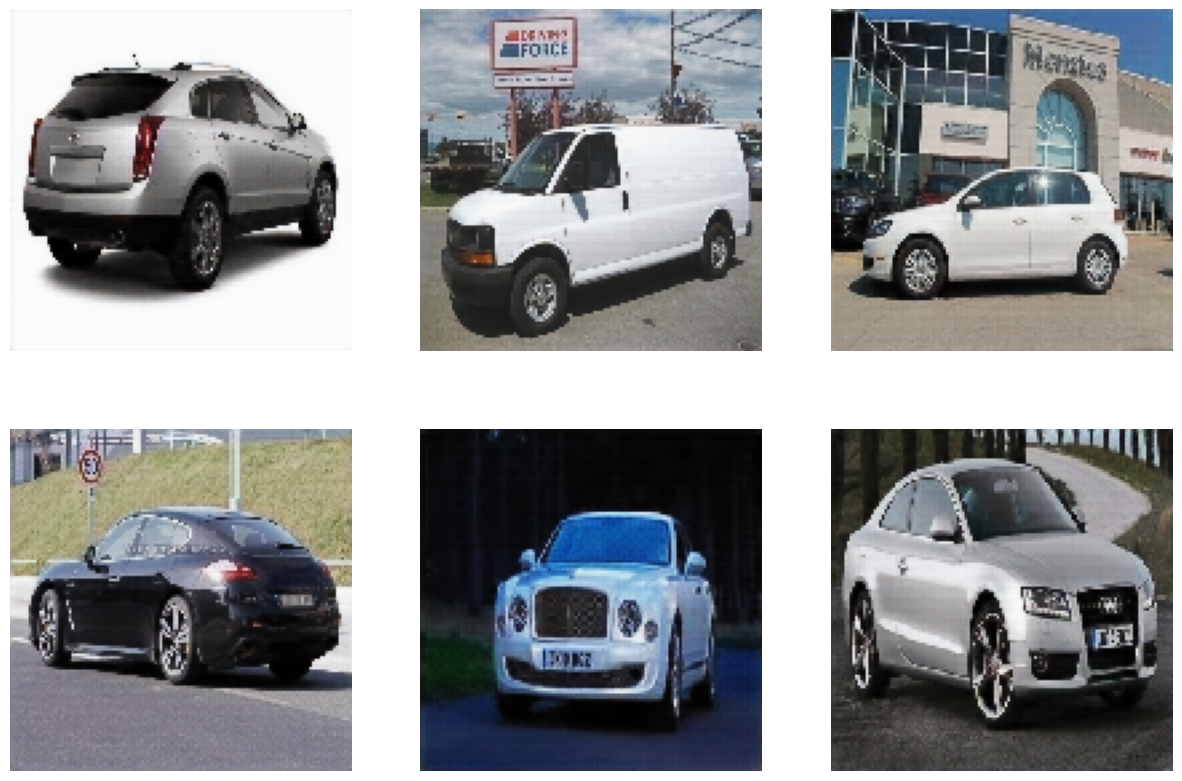

In [29]:
# Plot predictions
figs, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(predictions[i])
    ax.axis('off')